# Classification CHATS VS CHIENS


## Introduction

Ce notbook montre comment effectuer une classification d'images à partir de zéro, en partant de fichiers d'images JPEG sur le disque, sans utiliser de poids pré-entraînés ou de modèle Keras pré-fait. Nous présentons le flux de travail sur l'ensemble de données de classification binaire Cats vs Dogs de Kaggle.

Nous utilisons l'utilitaire `image_dataset_from_directory` pour générer les ensembles de données, et nous utilisons les couches de prétraitement d'images de Keras pour la normalisation des images et l'augmentation des données.

## Setup

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from PIL import Image
import matplotlib.pyplot as plt
import mlflow
from mlflow import keras as mlflow_keras
import psutil
import subprocess

## Num GPUs 

In [2]:

print(keras.__version__)
print(tf.version.VERSION)

2.9.0
2.9.1


In [3]:
# physical_devices = tf.config.list_physical_devices('GPU')
# if len(physical_devices) > 1:
#     tf.config.set_visible_devices(physical_devices[1], 'GPU')
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11446271224597017514
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1734606848
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2927784898917450853
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


## Charger les données : l'ensemble de données Cats vs Dogs
### Téléchargement des données brutes
Tout d'abord, téléchargeons l'archive ZIP de 786 Mo contenant les données brutes :

In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

In [ ]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

Maintenant, nous avons un dossier PetImages qui contient deux sous-dossiers, Cat et Dog. Chaque sous-dossier contient des fichiers image pour chaque catégorie.

In [ ]:
!ls PetImages

Cat  Dog


### Filtrer les images corrompues
Lorsque vous travaillez avec beaucoup de données d'images du monde réel, les images corrompues sont une occurrence courante. Filtrons les images mal codées qui ne contiennent pas la chaîne "JFIF" dans leur en-tête.

In [3]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 0 images.


## Générer un Dataset

In [4]:
# Définition de la taille des images et de la taille des lots
# image_size = (180, 180)
# batch_size = 64

image_size = (90, 90)
batch_size = 16

# Création des ensembles de données d'entraînement et de validation à partir du répertoire "PetImages"
# Avec une séparation de validation de 20%, incluant à la fois les données d'entraînement et de validation
# Une graine aléatoire est spécifiée pour la reproductibilité
# Les images sont redimensionnées à la taille spécifiée et les lots sont créés avec la taille spécifiée
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Using 4684 files for validation.


## Visualiser les données
Voici les neuf premières images dans l'ensemble de données d'entraînement.

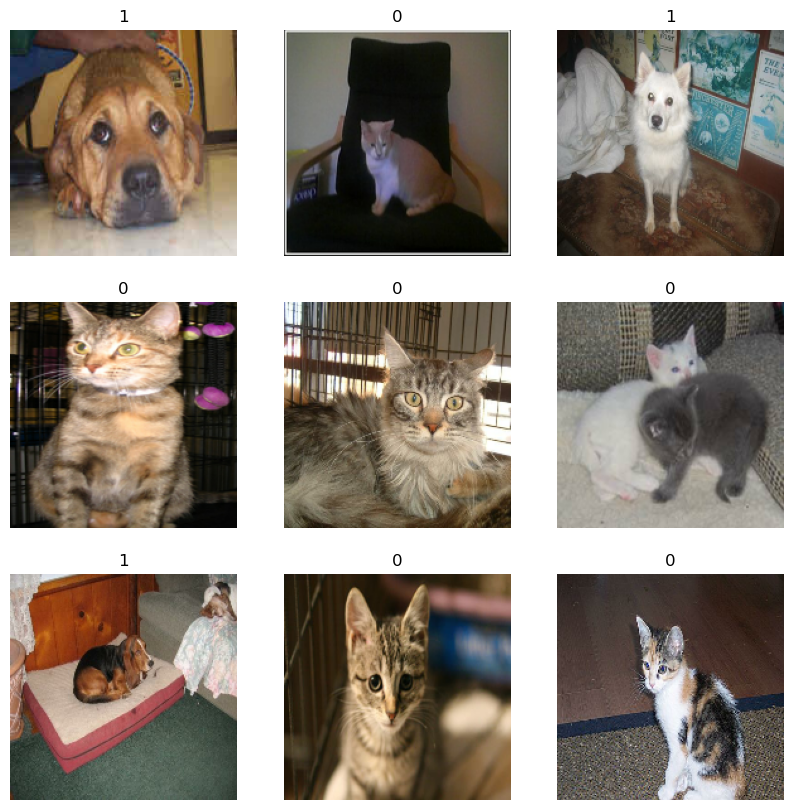

In [4]:

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i])) # type: ignore
        plt.axis("off")

## Utilisation de l'augmentation de données d'images
Lorsque vous n'avez pas un grand jeu de données d'images, il est bon de pratiquer l'introduction artificielle de diversité d'échantillons en appliquant des transformations aléatoires mais réalistes aux images d'entraînement, telles que des retournements horizontaux aléatoires ou de petites rotations aléatoires. Cela aide à exposer le modèle à différents aspects des données d'entraînement tout en ralentissant le surajustement.

In [5]:
# Augmentation des données
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images



Visualisons à quoi ressemblent les échantillons augmentés en appliquant data_augmentation de manière répétée aux premières images du jeu de données :

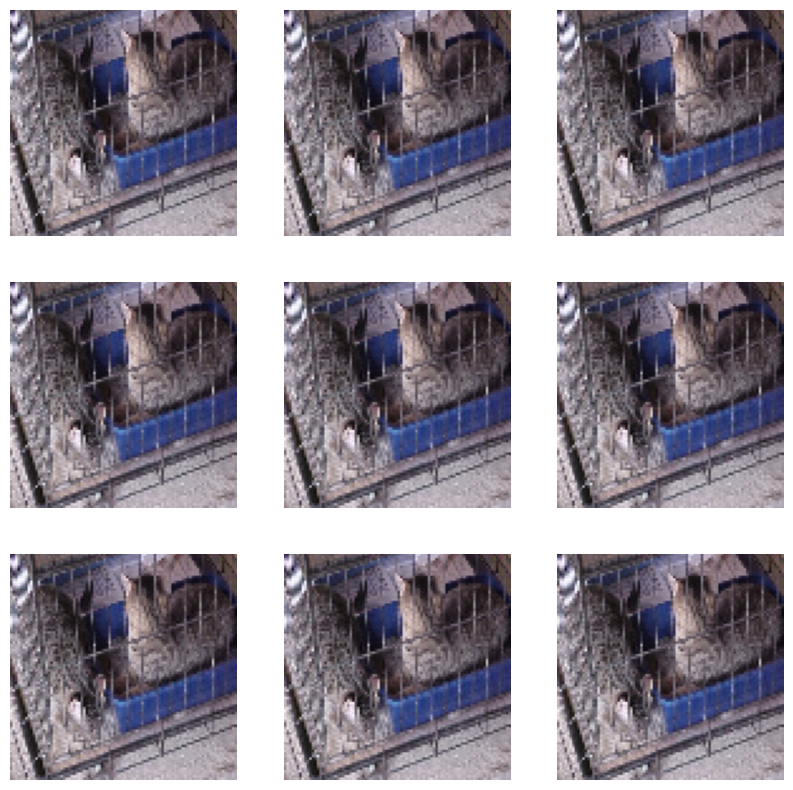

In [35]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")


## Normalisation des données
Nos images sont déjà dans une taille standard (180x180), car elles sont fournies sous forme de lots float32 contigus par notre ensemble de données. Cependant, les valeurs des canaux RGB sont dans la plage [0, 255]. Ce n'est pas idéal pour un réseau de neurones ; en général, vous devriez chercher à rendre vos valeurs d'entrée petites. Ici, nous allons normaliser les valeurs pour qu'elles soient dans la plage [0, 1] en utilisant une couche Rescaling au début de notre modèle.

## Deux options pour prétraiter les données
Il existe deux façons d'utiliser le préprocesseur data_augmentation :

**Option 1 : Intégrez-le dans le modèle, comme ceci :

```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
...  # Rest of the model
```

Avec cette option, votre augmentation de données se produira sur l'appareil, de manière synchrone avec le reste de l'exécution du modèle, ce qui signifie qu'elle bénéficiera de l'accélération GPU.

Notez que l'augmentation des données est inactive lors du test, donc les échantillons d'entrée ne seront augmentés que pendant fit(), pas lors de l'appel à evaluate() ou predict().

Si vous entraînez sur GPU, cela peut être une bonne option.

**Option 2 : Appliquez-la à l'ensemble de données, de sorte à obtenir un ensemble de données qui produit des lots d'images augmentées, comme ceci :


```python
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))
```

Avec cette option, votre augmentation de données se produira sur CPU, de manière asynchrone, et sera mise en mémoire tampon avant d'entrer dans le modèle.

Si vous entraînez sur CPU, c'est la meilleure option, car elle rend l'augmentation de données asynchrone et non bloquante.

Dans notre cas, nous choisirons la deuxième option. Si vous n'êtes pas sûr de laquelle choisir, cette deuxième option (prétraitement asynchrone) est toujours un choix solide.

## Configuration du jeu de données pour les performances
Appliquons l'augmentation des données à notre ensemble d'entraînement, et assurons-nous d'utiliser un préchargement tamponné afin de pouvoir extraire les données du disque sans bloquer les opérations d'entrée/sortie :

In [6]:
# Appliquer `data_augmentation` aux images d'entraînement.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
)

# ---------------------je doit tester--------------
# Le préchargement des échantillons dans la mémoire GPU aide à maximiser l'utilisation du GPU.



train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.experimental.AUTOTUNE)

## Construction d'un modèle
Nous allons construire une version réduite du réseau Xception. Nous n'avons pas particulièrement cherché à optimiser l'architecture ; si vous souhaitez effectuer une recherche systématique de la meilleure configuration de modèle, envisagez d'utiliser KerasTuner.

Notez que :

Nous commençons le modèle avec le préprocesseur data_augmentation, suivi d'une couche Rescaling.
Nous incluons une couche Dropout avant la couche de classification finale.

In [8]:
def make_model(input_shape, num_classes):
    # Crée une couche d'entrée avec la forme spécifiée
    inputs = keras.Input(shape=input_shape)

    # Réduit l'échelle des valeurs de pixel pour les ramener dans la plage [0,1]
    scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
    x = scale_layer(inputs)

    # Effectue une convolution avec 128 filtres de taille 3x3, décalage de 2 pixels et un remplissage "same"
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)

    # Normalise les activations de chaque couche
    x = layers.BatchNormalization()(x)

    # Applique la fonction d'activation ReLU
    x = layers.Activation("relu")(x)

    # Sauvegarde l'activation précédente pour les connexions résiduelles
    previous_block_activation = x

    # Itération sur différentes tailles de filtres convolutifs avec des connexions résiduelles
    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Ajoute une connexion résiduelle
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])

        # Sauvegarde l'activation pour la prochaine connexion résiduelle
        previous_block_activation = x

    # Ajoute une dernière couche de convolution, normalisation et activation
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Réduit la taille de l'entrée en prenant la moyenne de chaque carte de caractéristiques
    x = layers.GlobalAveragePooling2D()(x)

    # Applique une régularisation de type dropout
    x = keras.layers.Dropout(0.2)(x)

    # Ajoute une couche dense pour la classification
    # L'activation est fixée à None pour obtenir les logits
    if num_classes == 2:
        units = 1
    else:
        units = num_classes
    
    outputs = layers.Dense(units, activation="sigmoid")(x)
    

    # Crée et renvoie le modèle Keras avec les entrées et les sorties spécifiées
    return keras.Model(inputs, outputs)

# Crée une instance du modèle avec la taille d'image et le nombre de classes spécifiés
model = make_model(input_shape=image_size + (3,), num_classes=2)

# Affiche un diagramme du modèle montrant la connexion entre les différentes couches, avec les formes de sortie de chaque couche
# keras.utils.plot_model(model, show_shapes=True)


##  Model summary:

In [9]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 180, 180, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 90, 90, 128)  3584        ['rescaling_1[0][0]']            
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 90, 90, 128)  512        ['conv2d_4[0][0]']         

## Train the model

In [10]:
mlflow.set_experiment("Cat_vs_Dog_flom_scratch")
mlflow.tensorflow.autolog()

In [11]:
epochs = 25
with mlflow.start_run() as run:
    callbacks = [
        keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
    ]
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[keras.metrics.BinaryAccuracy()],
    )
    history = model.fit(
        train_ds,
        epochs=epochs,
        callbacks=callbacks,
        validation_data=val_ds,
    )
    
    # Sauvegarder le modèle dans MLflow
    mlflow.keras.log_model(model, "models")
    # Enregistrer le modèle
    model.save("my_model.h5")

mlflow.end_run()

2024/04/29 05:41:34 INFO mlflow.types.utils: MLflow 2.9.0 introduces model signature with new data types for lists and dictionaries. For input such as Dict[str, Union[scalars, List, Dict]], we infer dictionary values types as `List -> Array` and `Dict -> Object`. 
2024/04/29 05:41:36 INFO mlflow.types.utils: MLflow 2.9.0 introduces model signature with new data types for lists and dictionaries. For input such as Dict[str, Union[scalars, List, Dict]], we infer dictionary values types as `List -> Array` and `Dict -> Object`. 


Epoch 1/25
1172/1172 [==============================] - 76s 63ms/step - loss: 0.5757 - binary_accuracy: 0.6852 - val_loss: 1.0368 - val_binary_accuracy: 0.6482
Epoch 2/25
1172/1172 [==============================] - 75s 64ms/step - loss: 0.4121 - binary_accuracy: 0.8033 - val_loss: 0.4889 - val_binary_accuracy: 0.8209
Epoch 3/25
1172/1172 [==============================] - 75s 64ms/step - loss: 0.3241 - binary_accuracy: 0.8548 - val_loss: 0.3028 - val_binary_accuracy: 0.8719
Epoch 4/25
1172/1172 [==============================] - 74s 64ms/step - loss: 0.2647 - binary_accuracy: 0.8830 - val_loss: 0.4404 - val_binary_accuracy: 0.8514
Epoch 5/25
1172/1172 [==============================] - 75s 64ms/step - loss: 0.2231 - binary_accuracy: 0.9044 - val_loss: 0.2796 - val_binary_accuracy: 0.8888
Epoch 6/25
1172/1172 [==============================] - 74s 63ms/step - loss: 0.1886 - binary_accuracy: 0.9218 - val_loss: 0.3409 - val_binary_accuracy: 0.8894
Epoch 7/25
1172/1172 [==================

INFO:tensorflow:Assets written to: C:\Users\MOHAM\AppData\Local\Temp\tmplbfry3cq\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\MOHAM\AppData\Local\Temp\tmplbfry3cq\model\data\model\assets
2024/04/29 06:13:08 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\MOHAM\miniconda3\envs\tf\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils."
2024/04/29 06:13:09 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\MOHAM\AppData\Local\Temp\tmp9vc982_6\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\MOHAM\AppData\Local\Temp\tmp9vc982_6\model\data\model\assets


code de test

In [41]:
history.history

{'loss': [0.5757043957710266,
  0.4120577871799469,
  0.3241249918937683,
  0.26465368270874023,
  0.2230791300535202,
  0.1885586827993393,
  0.15863502025604248,
  0.13524678349494934,
  0.11717487126588821,
  0.09056439995765686,
  0.08973202854394913,
  0.08414441347122192,
  0.0761047825217247,
  0.06766317039728165,
  0.057127565145492554,
  0.05773608386516571,
  0.04529626667499542,
  0.046206653118133545,
  0.04740095138549805,
  0.04190591722726822,
  0.04423739016056061,
  0.037873946130275726,
  0.03629399463534355,
  0.03513152152299881,
  0.032010648399591446],
 'binary_accuracy': [0.6851851940155029,
  0.8033407926559448,
  0.8547870516777039,
  0.882965087890625,
  0.9043654799461365,
  0.9217632412910461,
  0.9339310526847839,
  0.9438574314117432,
  0.950101375579834,
  0.9626961350440979,
  0.9642437696456909,
  0.968246340751648,
  0.969793975353241,
  0.9724090099334717,
  0.9787063598632812,
  0.9767851233482361,
  0.9815348386764526,
  0.9819617867469788,
  0.982

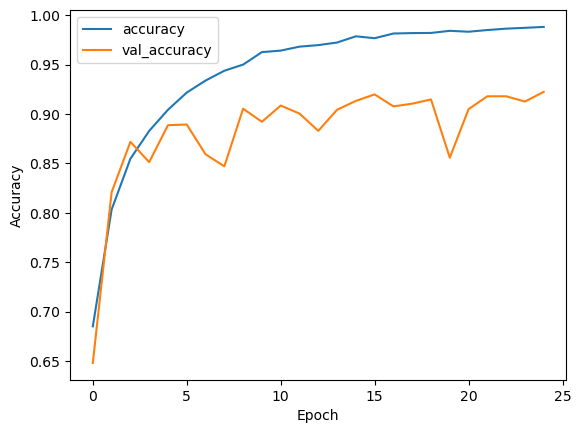

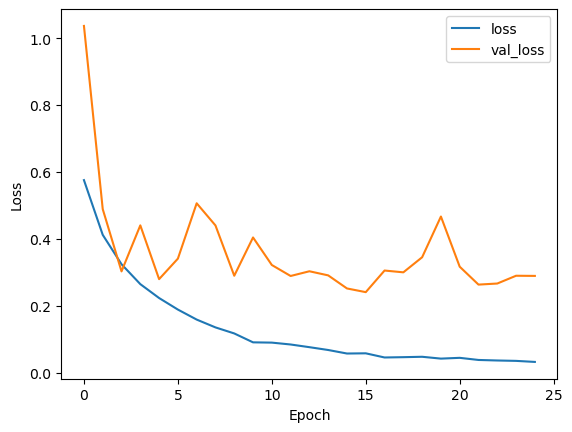

In [44]:
# # Afficher la courbe d'apprentissage
# plt.plot(history.history['acc'], label='accuracy')
# plt.plot(history.history['val_acc'], label='val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# # Afficher la courbe de perte
# plt.plot(history.history['loss'], label='loss')
# plt.plot(history.history['val_loss'], label='val_loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# Afficher la courbe d'accuracy
plt.plot(history.history['binary_accuracy'], label='accuracy')
plt.plot(history.history['val_binary_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Afficher la courbe de perte
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Pour afficher les resultat sans refit

We get to >90% validation accuracy after training for 25 epochs on the full dataset
(in practice, you can train for 50+ epochs before validation performance starts degrading).

## Run inference on new data

Note that data augmentation and dropout are inactive at inference time.

1/1 [==============================] - 0s 24ms/step
This image is 0.00% cat and 100.00% dog.


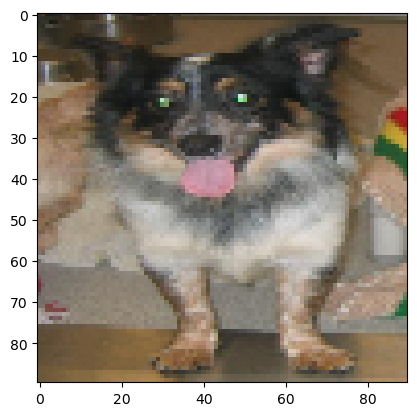

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Load and display the image
img = keras.utils.load_img("PetImages/Dog/6779.jpg", target_size=image_size)
plt.imshow(img)

# Convert the image to an array and add a batch axis
img_array = keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Make predictions using the model
predictions = model.predict(img_array)
score = float(predictions[0][0])  # Assuming you're using TensorFlow backend

# Print the prediction results
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")



In [47]:
from keras.models import load_model
import keras.backend as K
# Charger le modèle sauvegardé
loaded_model = load_model("my_model.h5")

# Utiliser le modèle chargé pour faire des prédictions
predictions_loaded = loaded_model.predict(img_array)
score_loaded = float(predictions_loaded[0][0])

# Afficher les résultats de la prédiction avec le modèle chargé
print(f"With loaded model, this image is {100 * (1 - score_loaded):.2f}% cat and {100 * score_loaded:.2f}% dog.")

1/1 [==============================] - 0s 153ms/step
With loaded model, this image is 0.00% cat and 100.00% dog.
